# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Curación (TP2)

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---

## Librerías

In [ ]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones propias
from utils_limpieza import * 

## Dataset

In [ ]:
# Cargar datos
path = '../data/raw/tp2_muestra_diplodatos_ventas_omega_modelo_2023.csv'
ventas = pd.read_csv(path)


---
# Preprocesamiento

## Limpieza sugerida al principio del TP2
- [x] Eliminar las variables en `cols_dropear` <span style="color:magenta">**(Paso 1)**</span>.
- [x] Renombrar a 'Otros' las subcategorías que no tengan `MODELO` <span style="color:magenta">**(Paso 2)**</span>.
- [x] Se eliminan los registros en 'Otros'. Previamente se almacenan en un dataset aparte.

In [ ]:
print(f'El df original tiene {ventas.shape[0]} registros y {ventas.shape[1]} variables.\n')

# Paso 1
cols_dropear = ['INSCRIPCION', 'CATEGORIA', 'DESCRIPCION_CATEGORIA', 'CATEGORIA (Ajustado)', 'NOMBRE']
ventas_renamed = limpiar_basic(ventas, cols_drop=cols_dropear)
print(f'Luego del paso 1 se tiran {len(cols_dropear)} variables, quedando {ventas_renamed.shape[1]} variables.\n')

# Paso 2
ventas_renamed = renombrar_elementos(ventas_renamed, 
                                     columna='SUB-CATEGORIA', 
                                     fill_otros='Otros')

scu_vr = ventas_renamed['SUB-CATEGORIA'].nunique()
scu_ot = ventas['SUB-CATEGORIA'].nunique() - scu_vr + 1
print(f'Luego del paso 2 quedan {scu_vr} subcategorías únicas.')
print(f'\tLas {scu_ot} subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".')
reg_ot = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] == 'Otros'].shape[0]
print(f'\t\t"Otros" cuenta con {reg_ot} registros >> {100*reg_ot/ventas.shape[0]:.2f}% del dataset original')
print(f'\nLas {scu_vr-1} subcategorías que sí tienen vendedores modelo son:')

ventas_renamed.groupby(by=['SUB-CATEGORIA'])['MODELO'].sum().sort_values(ascending=False)[:12]

In [ ]:
#Eliminación de registros en "Otros" y almacenamiento en un dataset aparte
ventas_otros = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] == 'Otros'].copy()
ventas_otros.to_csv('../data/interim/tp2_ventas_otros.csv', index=False)

ventas_renamed = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] != 'Otros'].copy()
print(ventas_renamed.shape)

## Análisis de datos faltantes
- [x] Chequear presencia de datos faltantes
- [x] Analizar su correlación
- [x] Imputar de valores faltantes: `CM` y `Trat_Dif` con 'No'.

Faltan datos en las mismas variables que antes. Imputo los complementos en `CM` y `Trat_Dif` para dejarlas listas. Luego de eso, se cumple lo que ya habíamos visto en el tp1.

In [ ]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

In [ ]:
ventas_renamed['CM04'] = ventas_renamed['CM04'].fillna('No')
ventas_renamed['TRATAMIENTO_DIFERNCIAL'] = ventas_renamed['TRATAMIENTO_DIFERNCIAL'].fillna('No')

In [ ]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

## Simplificación del nombre de las variables
- [x] Simplificamos el nombre de las variables.

In [ ]:
# Renombramos
with open("../references/tp2_column_dict.json") as column_dict_json:
    column_dict = json.load(column_dict_json)

ventas_renamed.rename(columns = column_dict, inplace = True)
ventas_renamed.columns

## Anonimizado
- [x] Anonimizamos la variable sensible `ID` <span style="color:magenta">**(Paso 3)**</span>.
- [x] Guardamos esto en un diccionario.

In [ ]:
# Anonimizamos y guardamos el diccionario para no perder esta info
ventas_hash, dict_id = anonimizar(ventas_renamed, 'ID')

with open("../references/tp2_ID_dict.json", "w") as fp:
    json.dump(dict_id, fp)

print('¡Diccionario generado!')

## Simplificación de valores posibles en ciertas variables
- [x] Simplificamos de valores en `Deposito`
- [x] Unificación y simplificación de categorías de `Trat_Fisc`.
- [x] Simplificación de categorías de `Trat_Fisc_Agg` y `Trat_Dif`.
- [x] Simplificación de categorías en `Categoria`.
- [x] Guardamos todos estos diccionarios.
- [x] CM: de Si/No a 1/0.

In [ ]:
# Mapeo de `Deposito` a enteros
ventas_hash, dict_dep = anonimizar(ventas_hash, 'Deposito')

with open("../references/tp2_deposito_dict.json", "w") as fp:
    json.dump(dict_dep, fp)

print('¡Diccionario generado!')

In [ ]:
# Unificacón y simplificación de categorías de `Trat_Fisc`
with open("../references/tp1_trat_fisc_dict.json") as trat_fisc_dict_json:
    trat_fisc_dict = json.load(trat_fisc_dict_json)
    
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].astype(str)
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].replace(trat_fisc_dict)

In [ ]:
# Simplificación de categorías de `Trat_Fisc_Agg`
with open("../references/tp1_trat_fisc_agg_dict.json") as trat_fisc_agg_dict_json:
    trat_fisc_agg_dict = json.load(trat_fisc_agg_dict_json)

ventas_hash['Trat_Fisc_Agg'] = ventas_hash['Trat_Fisc_Agg'].replace(trat_fisc_agg_dict)

In [ ]:
# Simplificación de categorías de `Trat_Dif`
with open("../references/tp1_trat_diff_dict.json") as trat_dif_dict_json:
    trat_dif_dict = json.load(trat_dif_dict_json)

ventas_hash['Trat_Dif'] = ventas_hash['Trat_Dif'].replace(trat_dif_dict)

In [ ]:
# Simplificación de categorías de `Subrubro`
with open("../references/tp2_subrubro_dict.json") as subrubro_dict_json:
    subrubro_dict = json.load(subrubro_dict_json)

ventas_hash['Subrubro'] = ventas_hash['Subrubro'].replace(subrubro_dict)

In [ ]:
ventas_hash['Subrubro'].unique()

In [ ]:
# Mapeo de `CM` según "Si" >> 1 y "No" >> 0.
ventas_hash['CM'] = ventas_hash['CM'].replace({'No': 0, 'Si': 1})

## Simplificación de variables temporales
Creamos la variable `Fecha` <span style="color:magenta">**(Paso 6)**</span>, que surge como:
    $$Fecha = Año + Mes$$

Luego vamos a optar por droppear `Mes` y `Año`. Aunque para el análisis temporal habrá momentos en que necesitamos tener `Año` y `Mes` por separado, son fácilmente recuperables a través de `Fecha`.

In [ ]:
ventas_hash["FECHA"] = pd.to_datetime(ventas_hash['Mes'].astype(str) + '-' + ventas_hash['Año'].astype(str), format='%m-%Y')
cols_dropear = ['Mes', 'Año']
ventas_hash = limpiar_basic(ventas_hash, cols_drop=cols_dropear)

ventas_hash[:3]

In [ ]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_hash.to_csv('../data/interim/tp2_ventas_hash.csv', index=False)

## Eliminación del efecto inflación
Las variables expresadas en pesos aumentan mes a mes por efecto de la inflación. Lo que impide comparar un valor monetario de un mes contra el del mes siguiente. A fin de eliminar este efecto, una alternativa es reexpresar los valores monetarios respecto a un mes base. Por ejemplo, el último mes de la serie.

In [ ]:
ventas_ipc = ventas_hash.copy()

In [ ]:
# Obtener el último mes
fecha = ventas_ipc['FECHA'].max()
print(f"El último mes de la serie es el {fecha.month} de {fecha.year}")

El procedimiento es el siguiente:
    $$\text{VAR}_{mm-aaaa} \frac{\text{IPC}_{06-2022}}{\text{IPC}_{mm-aaaa}}$$

Para todo valor de cada variable (VAR) correspondiente a cierto mes "mm-aaaa" se lo divide por el Índice de Precios al Consumidor (IPC) correspondiente a ese mes "mm-aaaa" y luego se lo multiplica por el IPC correspondiente al mes "06-2022".

De esta forma, todos los valores de cada variable VAR van a quedar expresados en unidades monetarias del "06-2022".



Es necesario obtener de manera externa una serie del IPC que publica Indec.

In [ ]:
precios_path = "../data/external/tp2_IPC_Indec.csv"

if exists(precios_path):
    print('Este archivo ya existe.')
else:
    print('Este archivo no existe: ¡Vamos a crearlo!')
    url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_23.xls"
    df = pd.read_excel(url, sheet_name="Índices IPC Cobertura Nacional", header=None, usecols="B:CA", skiprows=[0, 1, 2, 3, 4, 6, 7, 8], nrows=2)
    df = df.transpose()
    df.columns = ["FECHA", "INDICE"]
    df["FECHA"] = pd.to_datetime(df["FECHA"])
    df.to_csv(precios_path, index=False)

In [ ]:
# Abrir dataset de precios
precios = pd.read_csv(precios_path)
precios.head()

Luego debemos unir ambas bases de datos (ventas y precios), de acuerdo a la variable clave `FECHA`

In [ ]:
print(ventas_ipc["FECHA"].dtype)
print(precios["FECHA"].dtype)

In [ ]:
# Hay que asegurar que la variable clave tenga el mismo tipo en los dos dataframes
precios["FECHA"] = pd.to_datetime(precios["FECHA"])

In [ ]:
print(ventas_ipc["FECHA"].dtype)
print(precios["FECHA"].dtype)

In [ ]:
ventas_ipc = ventas_ipc.merge(precios[["FECHA", "INDICE"]], on="FECHA", how="left")
ventas_ipc.head(3)

La series que están expresadas en pesos son las siguientes: 
   * `Ventas`
   * `Comision`

In [ ]:
ventas_ipc.head()

In [ ]:
# Aplico la función para indexar valores respecto al último mes de la serie
indexar(ventas_ipc, 'Ventas')

In [ ]:
indexar(ventas_ipc, 'Comision')

Vemos gráficamente el efecto de la operación (por simplicidad se grafican mensualmente las series de tiempo agregando los valores por suma).

En las variantes llamadas "Reales", se observa una pendiente más moderada. El efecto de la inflación ha sido "descartado". De aquí en adelante, a la hora de hablar de los valores de estas variables, la interpretación correcta será "$ XX.XXX a precios de junio de 2022"

In [ ]:
ventas_ipc.head(3)

In [ ]:
# Se descartan las variables que no se usan
ventas_ipc = limpiar_basic(ventas_ipc, cols_drop=['Ventas', 'Comision', 'INDICE'])

# Se renombran las variables
ventas_ipc.rename(columns = {'FECHA': 'Fecha', 'Ventas_Real': 'Ventas', 
                              'Comision_Real': 'Comision'}, inplace = True)

# Se reacomodan las columnas
ventas_ipc = ventas_ipc[['ID', 'Omega', 'Subrubro', 'Trat_Fisc_Agg', 
                          'Trat_Fisc', 'Trat_Dif', 'CM', 'Fecha', 'Deposito', 
                          'Ventas', 'Alicuota', 'Comision', 'Modelo']]

ventas_ipc = ventas_ipc.sort_values(['Fecha', 'Ventas']).reset_index(drop=True)

In [ ]:
ventas_ipc

In [ ]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_ipc.to_csv('../data/interim/tp2_ventas_ipc.csv', index=False)

## Dataset resultante
El dataset original (`ventas`) teniá 435.489 registros y 19 variables. Luego de nuestro preprocesamiento nos quedamos con un dataset  (`ventas_ipc`) que tiene 378.708 registros y 13 variables.

In [ ]:
ventas.shape

In [ ]:
ventas_ipc.shape

---
# Análisis de variables numéricas

In [ ]:
if 'ventas_ipc' not in locals():
    # Para que las funciones se actualicen si tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_ipc = pd.read_csv('../data/interim/tp2_ventas_ipc.csv')

ventas_ipc.head()

In [ ]:
# Discrimanción por variables numércias
num_cols = ['Ventas', 'Alicuota', 'Comision']
ven_num = ventas_ipc[num_cols]

## Estadística descriptiva

- Vemos que en la variable `Alicuota` la dispersión de los datos está en el orden de la media, tomando valores desde 0% hasta 18%. Esto se ve reflejado en un z-Score que va desde -1 a 6 (igual al tp1).
- Esta tendencia a tener la cola derecha más larga también se nota en las otras dos variables. Sin embargo, en estos dos últimos casos la dispersión de datos es enorme: la desviación estándar es igual y un orden mayor que la media y el extremo superior del z-Score está en 83 y 108 para `Ventas` y `Comision`, respectivamente (mejoró respecto al tp1 gracias a la normalización por IPC).

In [ ]:
ven_num.describe().T

In [ ]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num[col].min() - ven_num[col].mean()) / ven_num[col].std()
    zScore_max = (ven_num[col].max() - ven_num[col].mean()) / ven_num[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

- Tanto `Ventas` como `Comision` tienen prácticamente un 42% de registros con valores nulos y un 0.32% de valores negativos, *i.e.* hay un 42-43% de registros con valores no positivos imputados. 
- Un valor nulo significa que o bien era realmente nulo o se encontraba entre -$100 y $1000 (en la variable original de ventas).
- `Alicuota` no posee registros negativos, pero sí tiene un 0.63% de registros nulos.

In [ ]:
print('Proporción de valores negativos, nulos y positivos en las variables numéricas:') 
for col in num_cols:
    print(f'\t{col}')
    ans = len(ven_num[col])
    neg = len(ven_num[ven_num[col] < 0])
    nul = len(ven_num[ven_num[col] == 0])

    cant = [neg, nul, neg+nul, ans-neg-nul, ans]
    prop = [f'{100*neg/ans:.2f}%', f'{100*nul/ans:.2f}%', f'{100*(nul+neg)/ans:.2f}%', f'{100*(ans-nul-neg)/ans:.2f}%', '100.00%']
    desc = pd.DataFrame([cant, prop], columns=['Negativos', 'Nulos', 'No positivos', 'Positivos', 'Total'], index=['Cantidad', 'Proporcion'])
    display(desc)


In [ ]:
sns.pairplot(data=ven_num, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

In [ ]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

## Discriminando por tipo de venta
Dado el enorme peso de los valores nulos sobre el total de registros y la presencia de valores negativos, tanto en `Ventas` como en `Comision`, se decide dividir este DataFrame en tres:
1. Filtrado por `Ventas` nulas (`ven_num_null`)
2. Filtrado por `Ventas` negativas (`ven_num_neg`)
2. Filtrado por `Ventas` positivas (`ven_num_pos`)

### DataFrame con todas las ventas nulas
Al hacer esto, vemos que todos los valores de `Comision` en `ven_num_null` también son nulos, independientemente del valor de `Alicuota`, la cual sigue ocupando el rango de 0% a 18%.

In [ ]:
ven_num_null = ven_num[ven_num['Ventas'] == 0].copy()
ven_num_null.describe().T

In [ ]:
print('z-Score de los extremos de la variables numéricas:') 
for col in ['Alicuota']:
    zScore_min = (ven_num_null[col].min() - ven_num_null[col].mean()) / ven_num_null[col].std()
    zScore_max = (ven_num_null[col].max() - ven_num_null[col].mean()) / ven_num_null[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

### DataFrame con todas las ventas negativas
- Hay 7 órdenes de magnitud de diferencia entre los valores mínimo y máximo de ventas y comisión.
- Los datos son asimétricos hacia la izquierda, igual son menos asimétricos que el conjunto global
- Hay 26 casos donde la comisión es nula a pesar de que la venta no fue nula. En 25 de estos casos ocurre que la alícuota es cero. En el caso restante es de 0.18%. Como en todos los casos son ventas negativas, puede ser que esta sea la razón de tener una comisión nula. Ninguno de estos 26 registros corresponde a vendedor modelo.
- De hecho no hay ningún modelo con ventas negativas.

In [ ]:
ven_num_neg = ven_num[ven_num['Ventas'] < 0].copy()
ven_num_neg.describe().T

In [ ]:
mod_neg = ventas_ipc[num_cols+['Modelo']]
mod_neg = mod_neg[mod_neg['Ventas'] < 0]
mod_neg = mod_neg[ventas_ipc['Modelo'] == 1]
mod_neg

In [ ]:
ventas_ipc[(ventas_ipc['Ventas'] < 0) & (ventas_ipc['Comision'] == 0)].sort_values('Alicuota')[num_cols+['Modelo']]

In [ ]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num_neg[col].min() - ven_num_neg[col].mean()) / ven_num_neg[col].std()
    zScore_max = (ven_num_neg[col].max() - ven_num_neg[col].mean()) / ven_num_neg[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

* La mayoría de las ventas y comisiones están asociadas a alícuotas menores al 5% (con moda en 5%).
* Se proyecta una relación lineal entre `Ventas` y `Comision`: hay una correlación de +0.66. Chequear relación de proporcionaldiad con `Alicuota`

In [ ]:
sns.pairplot(data=ven_num_neg, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

In [ ]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num_neg[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

### DataFrame con todas las ventas positivas
* Hay 5 y 9 órdenes de magnitud de diferencia entre los valores mínimo y máximo de comisión y ventas, respectivamente.
* Los datos son asimétricos hacia la derecha, igual son menos asimétricos que el conjunto global.
* Hay 2232 casos donde la comisión es nula a pesar de que la venta no fue nula. De estos:
    * 34 registros corresponden a vendedores modelo.
    * 1458 registros con alícuota nula.
    * 774 registros con alícuota no nula.

In [ ]:
ven_num_pos = ven_num[ven_num['Ventas'] > 0].copy()
ven_num_pos.describe().T

In [ ]:
a = ventas_ipc[(ventas_ipc['Ventas'] > 0) & (ventas_ipc['Comision'] == 0)].sort_values('Alicuota')[num_cols+['Modelo']]
display(a)
print(f'Hay {len(a)} registros con venta positiva, pero comisión nula. De estos:')
print(f'\t>>> {len(a[a["Modelo"] == 1])} registros corresponden a vendedores modelo.')
display(a[a["Modelo"] == 1].describe().T)
print(f'\t>>> {len(a[a["Alicuota"] == 0])} registros con alícuota nula.')
print(f'\t>>> {len(a[a["Alicuota"] > 0])} registros con alícuota no nula.')
display(a[a["Alicuota"] > 0].describe().T)

In [ ]:
print('z-Score de los extremos de la variables numéricas:') 
for col in num_cols:
    zScore_min = (ven_num_pos[col].min() - ven_num_pos[col].mean()) / ven_num_pos[col].std()
    zScore_max = (ven_num_pos[col].max() - ven_num_pos[col].mean()) / ven_num_pos[col].std()

    print(f'\t{col}:')
    print(f'\t\t Mínimo: {zScore_min:.0f} \t Máximo: {zScore_max:.0f}')

* La mayoría de las ventas y comisiones están asociadas a alícuotas menores al 5%.
* Hay una distribución bimodal en torno al 0.0475% y el 5%
* Se proyectan diferentes rectas entre `Ventas` y `Comision`: ¿existe una relación de proporcionaldiad con `Alicuota`?
* Se proyecta una relación lineal entre `Ventas` y `Comision`: hay una correlación de +0.87. Chequear relación de proporcionaldiad con `Alicuota`

In [ ]:
sns.pairplot(data=ven_num_pos, diag_kind='kde', plot_kws = {'alpha': 0.3, 's': 10})
plt.show()

In [ ]:
# Cálculo y Visualización de la matriz de correlación entre las variables
matrix = ven_num_pos[['Ventas', 'Alicuota', 'Comision']].corr().round(2)
sns.heatmap(matrix, annot=True)

## Más medidas de dispersión sobre ventas no nulas: asimetría y Kurtosis

Al analizar la asimetría (skewness) y la Kurtosis sobre estas variables decimos que:
* Las ventas positivas tienen un sesgo positivos y las negativas un sesgo negativo tanto para comisión como para ventas, como ya habíamos visto: las colas de las distribuciones se encuentran a derecha e izquierda, respectivamente.
* Las comisiones siempre tienen sesgo positivo: colas a derecha.
* Todas son leptocúrticas: están más apuntaladas y con colas más gruesas que la normal.
* Todos los p-valores son nulos en ambos test, lo cual indica que rechazamos la hipótesis nula: tanto en simetría como en Kurtosis las distribuciones son significativamente diferentes a una distribución normal.

In [ ]:
print('Ventas negativas')
asim = skew(ven_num_neg)
asimtest = skewtest(ven_num_neg).pvalue
kurt = kurtosis(ven_num_neg)
kurttest = kurtosistest(ven_num_neg).pvalue

desc = pd.DataFrame({'Asimetría': asim, 'p-val Asim.': asimtest,
                     'Kurtosis (Fisher)': kurt, 'p-val Kurt.': kurttest},
                     index=['Ventas', 'Alicuota', 'Comision'])
desc

In [ ]:
print('Ventas positivas')
asim = skew(ven_num_pos)
asimtest = skewtest(ven_num_pos).pvalue
kurt = kurtosis(ven_num_pos)
kurttest = kurtosistest(ven_num_pos).pvalue

desc = pd.DataFrame({'Asimetría': asim, 'p-val Asim.': asimtest,
                     'Kurtosis (Fisher)': kurt, 'p-val Kurt.': kurttest},
                     index=['Ventas', 'Alicuota', 'Comision'])
desc

## Relación entre variables numéricas con etiquetas categóricas

In [ ]:
ventas_null = ventas_ipc[ventas_ipc['Ventas'] == 0].copy()
ventas_neg = ventas_ipc[ventas_ipc['Ventas'] < 0].copy()
ventas_pos = ventas_ipc[ventas_ipc['Ventas'] > 0].copy()

### Ventas nulas
- Omega: prácticamente todos 1. Hay una nadita de 0.
- Subrubro: nada particular.
- Trat_Fisc_Agg: casi todos normales, algunos exentos y ni se ven los otros.
- Trat_Fisc: la enorme mayoría son 0. Después destacan apenitas los normales.
- Trat_Dif: la enorme mayoría no tiene. espués destacan apenitas los artículos 16 y 21.
- CM: prácticamente todos 0. Hay una nadita de 1. Se repite lo que vimos en el tp1: todos los CM1 están acá. Identificar a este vendedor y eliminar.
- Modelo: la gran mayoría no lo son, aunque sí hay varios modelo (en torno al cero).

In [ ]:
# # Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

# for col in ['Omega', 'Subrubro', 'Trat_Fisc_Agg', 'Trat_Fisc', 'Trat_Dif', 'CM', 'Modelo']:
#     sns.kdeplot(data=ventas_null[['Alicuota', col]], x='Alicuota', hue=col)
#     plt.show()

### Ventas negativas
- Omega: todos son 1.
- Subrubro: destacan misceláneo, supermercados y combustible reventa.
- Trat_Fisc_Agg: la enorme mayoría son normal, una nada de exentos. No hay otros.
- Trat_Fisc: nada particular.
- Trat_Dif: mayoritariamente no.
- CM: todos son 0.
- Modelo: todos son 0 (no hay ningún modelo con ventas negativas).

In [ ]:
# # Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

# for col in ['Omega', 'Subrubro', 'Trat_Fisc_Agg', 'Trat_Fisc', 'Trat_Dif', 'CM', 'Modelo']:
#     sns.pairplot(data=ventas_neg[num_cols+[col]], diag_kind='kde', hue=col, plot_kws = {'alpha': 0.3, 's': 10})
#     plt.show()

### Ventas positivas
- Omega: la enorme mayoría son 1. Hay poquititos 0.
- Subrubro: ver cómo se asocian a las diferentes proyecciones.
- Trat_Fisc_Agg: casi todo normal. Algunos otros. También hay exento y mínimo.
- Trat_Fisc: sumar esto al análisis de subrubro (distinguir primero por subrubro y dentro de cada uno diferenciar entre Trat Fisc).
- Trat_Dif: como el item anterior.
- CM: todos son 0.
- Modelo: hay tanto 0 como 1. Hay una mayor proporción de 1 que antes

In [ ]:
# # Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

# for col in ['Omega', 'Subrubro', 'Trat_Fisc_Agg', 'Trat_Fisc', 'Trat_Dif', 'CM', 'Modelo']:
#     sns.pairplot(data=ventas_pos[num_cols+[col]], diag_kind='kde', hue=col, plot_kws = {'alpha': 0.3, 's': 10})
#     plt.show()

## Nota sobre modelos
* No hay ningún modelo con ventas nulas: la mayoría de sus registros son ventas positivas, aunque hay algunos con ventas negativas.
* Todos los modelos tienen alícuotas bajas (muy ceranas al 0%). Hay 5374 registros asociados a vendedores modelo y sus alícuotas van desde 0.0084% hasta 3.25%. Sin embargo, la mayoría se concentra en alícuotas menores a 0.075 %, teniendo un pico en 0.05%.

In [ ]:
a = ventas_ipc[(ventas_ipc['Modelo'] == 1)].sort_values('Alicuota')[num_cols]
a.describe().T

In [ ]:
sns.histplot(a['Alicuota'])
plt.show()

sns.histplot(a[a['Alicuota'] < 0.5]['Alicuota'])
plt.show()

## Análisis de la relación de proporcionalidad entre variables numéricas

Queremos estudiar un poco más la relación lineal antes vista entre estas 3 variables. Proponemos que la función que las relaciona es
    $$\text{Comision} = \text{Alicuota} \times \text{Ventas}$$

Acá voy a volver a distinguir entre nulas, positivas y negativas e ir discriminando por modelo

### Ventas nulas
Los 147061 registros con ventas nulas cumplen la relación (porque dijimos que toda venta nula estaba asociada a una comision nula).

In [ ]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_null['Alicuota'] * ventas_null['Ventas']

L = len(calcCom)
S = sum(abs(ventas_null['Comision'] - calcCom) == 0)
print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

### Ventas negativas
* El 97.65% de los registros **NO** cumplen la relación: el 96.19% de los registros la subestiman.
* El 64.05% de los registros cae en el caso *pendiente grande*.

In [ ]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_neg['Alicuota'] * ventas_neg['Ventas']

diff = ventas_neg['Comision'] - calcCom
D = len(diff)
L = len(calcCom)
S = sum(abs(diff) == 0)

print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

sobre = len(diff[diff<0])
print(f'\t{sobre} registros sobreestiman la relación >>> {100*sobre/D:.2f}%')
sub = len(diff[diff>0])
print(f'\t{sub} registros subestiman la relación >>> {100*sub/D:.2f}%')

In [ ]:
com_real_sobre = ventas_neg['Comision'][diff<0]
com_real_exac = ventas_neg['Comision'][diff==0]
com_real_sub = ventas_neg['Comision'][diff>0]

com_calc_sobre = calcCom[diff<0]
com_calc_exac = calcCom[diff==0]
com_calc_sub = calcCom[diff>0]

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))

fig.suptitle('Comisión: real vs calculada (ventas negativas)')

axs.scatter(com_real_sobre, com_calc_sobre, label='Sobreestimado', s=30)
axs.scatter(com_real_exac, com_calc_exac, label='Exacto', s=20)
axs.scatter(com_real_sub, com_calc_sub, label='Subestimado', s=10)

axs.legend()

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

plt.show()

In [ ]:
rg_real = pd.concat([com_real_sub[com_calc_sub<0], com_real_sobre[com_calc_sobre>10*com_real_sobre]])
rg_calc = pd.concat([com_calc_sub[com_calc_sub<0], com_calc_sobre[com_calc_sobre>10*com_real_sobre]])

rp_real = pd.concat([com_real_sub[com_calc_sub>0], com_real_sobre[com_calc_sobre<10*com_real_sobre], com_real_exac])
rp_calc = pd.concat([com_calc_sub[com_calc_sub>0], com_calc_sobre[com_calc_sobre<10*com_real_sobre], com_calc_exac])

In [ ]:
print(f'De los {len(rp_real+rg_real)} registros:')
print(f'\t{len(rg_real)} están en la recta con pendiente grande >>> {100*len(rg_real)/len(rp_real+rg_real):.2f}%')
print(f'\t{len(rp_real)} están en la recta con pendiente pequeña >>> {100*len(rp_real)/len(rp_real+rg_real):.2f}%')

In [ ]:
LG = LR(rg_real, rg_calc)
LP = LR(rp_real, rp_calc)

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(rg_real, rg_real*LG.slope + LG.intercept, label=f'{LG.slope:.0f}*Real + ${LG.intercept:.0f}', color='red')
axs.plot(rp_real, rp_real*LP.slope + LP.intercept, label=f'{LP.slope:.0f}*Real + ${LP.intercept:.4f}', color='tab:green')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada (ventas negativas)')
plt.show()

In [ ]:
# Discrimino por modelo
mask0 = ventas_neg['Modelo']==0
mask1 = ventas_neg['Modelo']==1

In [ ]:
com_real_Mod = ventas_neg['Comision'][mask1]
com_real_noMod = ventas_neg['Comision'][mask0]

com_calc_Mod = calcCom[mask1]
com_calc_noMod = calcCom[mask0]

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(com_real_noMod, com_calc_noMod, label='No Modelo', color='tab:green')
axs.plot(com_real_Mod, com_calc_Mod, label='Modelo', color='red')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión Calculada')

fig.suptitle('Comisión: real vs calculada (ventas negativas)')
plt.show()

### Ventas positivas
* El 97.33% de los registros **NO** cumplen la relación: el 81.64% de los registros la sobrestiman.
* Todos los que no cumplen caen en el caso *pendiente grande*.
* Todos os modelo caen en el caso *pendiente pequeña*.

In [ ]:
# Relación lineal: comision = alicuota x venta
calcCom = ventas_pos['Alicuota'] * ventas_pos['Ventas']

diff = ventas_pos['Comision'] - calcCom
D = len(diff)
L = len(calcCom)
S = sum(abs(diff) == 0)

print(f'{S} de {L} registros cumplen la relación >> {100*(S)/L:.2f}%')
print(f'{L-S} registros no la cumplen la relación >> {100*(L-S)/L:.2f}%')

sobre = len(diff[diff<0])
print(f'\t{sobre} registros sobreestiman la relación >>> {100*sobre/D:.2f}%')
sub = len(diff[diff>0])
print(f'\t{sub} registros subestiman la relación >>> {100*sub/D:.2f}%')

In [ ]:
com_real_sobre = ventas_pos['Comision'][diff<0]
com_real_exac = ventas_pos['Comision'][diff==0]
com_real_sub = ventas_pos['Comision'][diff>0]

com_calc_sobre = calcCom[diff<0]
com_calc_exac = calcCom[diff==0]
com_calc_sub = calcCom[diff>0]

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))

fig.suptitle('Comisión: real vs calculada (ventas positivas)')

axs.scatter(com_real_sobre, com_calc_sobre, label='Sobreestimado', s=30)
axs.scatter(com_real_exac, com_calc_exac, label='Exacto', s=20)
axs.scatter(com_real_sub, com_calc_sub, label='Subestimado', s=10)

axs.legend()

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

plt.show()

In [ ]:
rg_real = pd.concat([com_real_sub[com_calc_sub<0], com_real_sobre[com_calc_sobre>10*com_real_sobre]])
rg_calc = pd.concat([com_calc_sub[com_calc_sub<0], com_calc_sobre[com_calc_sobre>10*com_real_sobre]])

rp_real = pd.concat([com_real_sub[com_calc_sub>0], com_real_sobre[com_calc_sobre<10*com_real_sobre], com_real_exac])
rp_calc = pd.concat([com_calc_sub[com_calc_sub>0], com_calc_sobre[com_calc_sobre<10*com_real_sobre], com_calc_exac])

In [ ]:
print(f'De los {len(rp_real+rg_real)} registros:')
print(f'\t{len(rg_real)} están en la recta con pendiente grande >>> {100*len(rg_real)/len(rp_real+rg_real):.2f}%')
print(f'\t{len(rp_real)} están en la recta con pendiente pequeña >>> {100*len(rp_real)/len(rp_real+rg_real):.2f}%')

In [ ]:
LG = LR(rg_real, rg_calc)
LP = LR(rp_real, rp_calc)

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(rg_real, rg_real*LG.slope + LG.intercept, label=f'{LG.slope:.0f}*Real + ${LG.intercept:.0f}', color='red')
axs.plot(rp_real, rp_real*LP.slope + LP.intercept, label=f'{LP.slope:.0f}*Real + ${LP.intercept:.4f}', color='tab:green')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión calculada')

fig.suptitle('Comisión empresa: real vs calculada (ventas positivas)')
plt.show()

In [ ]:
# Discrimino por modelo
mask0 = ventas_pos['Modelo']==0
mask1 = ventas_pos['Modelo']==1

In [ ]:
com_real_Mod = ventas_pos['Comision'][mask1]
com_real_noMod = ventas_pos['Comision'][mask0]

com_calc_Mod = calcCom[mask1]
com_calc_noMod = calcCom[mask0]

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))

axs.scatter(rg_real, rg_calc, label='Gran pendiente', s=30)
axs.scatter(rp_real, rp_calc, label='Pequeña pendiente', s=15)
axs.plot(com_real_noMod, com_calc_noMod, label='No Modelo', color='tab:green')
axs.plot(com_real_Mod, com_calc_Mod, label='Modelo', color='red')

axs.legend(loc='upper left')

axs.set_xlabel('Comisión real')
axs.set_ylabel('Comisión Calculada')

fig.suptitle('Comisión: real vs calculada (ventas positivas)')
plt.show()

### Pendientes
* En ambos casos de ventas no nulas las pendientes son 1 y 100 para la pequeña y la grande, respectivamente.
* Las ordenadas al origen son bien diferentes para cada caso:
    * Ventas negativas:
        * Pendiente = 1 >> $0
        * Pendiente = 100 >> $141.739
    * Ventas positivas:
        * Pendiente = 1 >> -$21
        * Pendiente = 100 >> $1.719

---
# Análisis de variables categóricas

In [ ]:
if 'ventas_ipc' not in locals():
    # Para que las funciones se actualicen si tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_ipc = pd.read_csv('../data/interim/tp2_ventas_ipc.csv')

ventas_ipc.head()

In [ ]:
ventas_categ = ventas_ipc.drop(['Ventas', 'Alicuota', 'Comision'], axis=1).copy()
ventas_categ.head(3)

## Chequear unicidad: relación con modelos

### `ID` y `Modelo`

In [ ]:
checkear_unicidad(ventas_categ, 'Modelo', 'ID')

Esto implica, que si hay un vendedor Modelo que vende en más de un rubro, tiene la etiqueta de Modelo en todos los rubros.

### `Omega` y `Modelo`

En primer lugar, verificar si a cada ID único se le asigna un único valor de Omega (no debería pasar lo contrario)

In [ ]:
checkear_unicidad(ventas_categ, 'Omega', 'ID')

In [ ]:
graficar_modelo(ventas_categ, 'Omega')

Dentro de los vendedores que son Omega (3119), solo el 0,35% es modelo.
Mientras que entre los no Omega (26), el 100% es modelo.

### `Subrubro` y `Modelo`

In [ ]:
checkear_unicidad(ventas_categ, 'Subrubro', 'ID')

En secciones previas se probó que si un ID era Modelo en un rubro, también lo era en todos en los que aparecía.

In [ ]:
graficar_modelo(ventas_categ, 'Subrubro')

### `Trat_Fisc_Agg` y `Modelo`

De qué depende el tratamiento fiscal? Del cliente? Del vendedor? Del rubro? De cada venta?

In [ ]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID')

Esto prueba que el atributo Trat_Fisc_Agg no es el mismo para todas las ventas de un vendedor.

Probemos si para cada vendedor, de cierto rubro, de cierto número de depósito se cumple:

In [ ]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID', 'Deposito','Subrubro')

Será un atributo que cambia en el tiempo?

In [ ]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID', 'Deposito', 'Subrubro', 'Fecha')

Esto no contradice lo que pusimos en el data statement? Que cada renglón es una sumatoria de ventas para un mismo ID, en cierto Deposito y cierto mes?

In [ ]:
#Un caso:
ventas_categ[(ventas_categ['ID'] == 691) & (ventas_categ['Deposito'] == 70) & (ventas_categ['Subrubro'] == 'Comb.') & (ventas_categ['Fecha'] == '2019-11-01')]

De cualquier manera, esto hace pensar que el tratamiento fiscal depende del cliente o de la venta en particular y no del vendedor.

#### Checkear con `Ventas` si hay cierto punto de corte para entrar por ej desde exento a normal y luego a otro

In [ ]:
ventas_prueba = ventas_ipc[['ID', 'Deposito', 'Subrubro', 'Fecha','Ventas','Trat_Fisc_Agg']].dropna(subset=['Trat_Fisc_Agg']).copy()
duplicados = ventas_prueba[ventas_prueba.duplicated(subset=['ID', 'Deposito', 'Subrubro', 'Fecha'], keep=False)].sort_values(by=['ID', 'Deposito', 'Subrubro', 'Fecha'], ascending=True).copy()
duplicados

In [ ]:
duplicados.groupby('Trat_Fisc_Agg')['Ventas'].mean()

En promedio, se cumple que "Exento" es menor a "Norm", que a su vez es menor a "Otro". Veamos si se cumple en todos los casos:

Si resultado es True, significa que, dentro de cada grupo, el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Exento' siempre es menor que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Normal', y ambos son menores que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Otro'. Si resultado es False, significa que al menos en un grupo no se cumple esta condición.

In [ ]:
resultado = duplicados.groupby(['ID', 'Deposito', 'Subrubro', 'Fecha']).apply(lambda x: x[x['Trat_Fisc_Agg'] == 'Exento']['Ventas'].max() < x[x['Trat_Fisc_Agg'] == 'Norm']['Ventas'].min() < x[x['Trat_Fisc_Agg'] == 'Otro']['Ventas'].min()).all()
resultado

In [ ]:
graficar_modelo(ventas_categ, 'Trat_Fisc_Agg')

### `Trat_Fisc` y `Modelo`

In [ ]:
checkear_unicidad(ventas_categ, 'Trat_Fisc', 'ID', 'Deposito', 'Subrubro', 'Fecha')

##### Checkear con `Ventas` si hay cierto punto de corte para pasar de una a otra categoría

In [ ]:
ventas_prueba = ventas_ipc[['ID', 'Deposito', 'Subrubro', 'Fecha','Ventas','Trat_Fisc']].dropna(subset=['Trat_Fisc']).copy()
duplicados = ventas_prueba[ventas_prueba.duplicated(subset=['ID', 'Deposito', 'Subrubro', 'Fecha'], keep=False)].sort_values(by=['ID', 'Deposito', 'Subrubro', 'Fecha'], ascending=True).copy()
duplicados.groupby('Trat_Fisc')['Ventas'].mean()

Probamos con un caso.

Si resultado es True, significa que, dentro de cada grupo, el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 0 siempre es mayor que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 1. Si resultado es False, significa que al menos en un grupo no se cumple esta condición.

In [ ]:
resultado = duplicados.groupby(['ID', 'Deposito', 'Subrubro', 'Fecha']).apply(lambda x: x[x['Trat_Fisc'] == 0]['Ventas'].max() > x[x['Trat_Fisc'] == 1]['Ventas'].min()).all()
resultado

In [ ]:
graficar_modelo(ventas_categ, 'Trat_Fisc')

### `Trat_Dif` y `Modelo`

In [ ]:
checkear_unicidad(ventas_categ, 'Trat_Dif', 'ID', 'Deposito', 'Subrubro', 'Fecha')

In [ ]:
checkear_unicidad(ventas_categ, 'Trat_Dif', 'ID', 'Deposito', 'Subrubro')

Se debe a que `Trat_Dif` cambia en el tiempo? O a que hay pocos casos con valores no vacíos?

In [ ]:
graficar_modelo(ventas_categ, 'Trat_Dif')

### `CM` y `Modelo` <span style="color:magenta">**(Paso 4)**</span>

In [ ]:
checkear_unicidad(ventas_categ, 'CM', 'ID')

In [ ]:
casos_unicos_cm_1 = ventas_categ[ventas_categ['CM'] == 1]['ID'].nunique()
print("Número de casos únicos de ID para CM = 1:", casos_unicos_cm_1)

In [ ]:
graficar_modelo(ventas_categ, 'CM')

Solo hay un caso que está bajo CM igual a 1 (y no es vendedor modelo). El tamaño de muestra equivale al 0,01% de los casos.

In [ ]:
print(f"{round(len(ventas_categ[ventas_categ['CM'] == 1]) / len(ventas_categ) * 100, 2)}%")

Se procederá a descartar el caso en un dataset aparte. Y se eliminará la variable `CM`.

In [ ]:
#Eliminación de caso CM=1 y columna CM. Y almacenamiento en un dataset aparte

# Se opera sobre el dataset completo

ventas_cm = ventas_ipc[ventas_ipc['CM'] == 1].copy()
ventas_cm.to_csv('../data/interim/tp2_ventas_cm.csv', index=False)

display(ventas_cm[['Ventas']])

ventas_ipc = ventas_ipc[ventas_ipc['CM'] != 1].copy()
ventas_ipc = limpiar_basic(ventas_ipc, 'CM')

# Y luego sobre el dataset de variables categóricas

ventas_categ = ventas_categ[ventas_categ['CM'] != 1].copy()
ventas_categ = limpiar_basic(ventas_categ, 'CM')
ventas_categ

## Relación entre variables fiscales (`Trat_Fisc` y `Trat_Fisc_Agg` y `Trat_Dif`) <span style="color:magenta">**(Paso 5)**</span>

### `Trat_Fisc` y `Trat_Fisc_Agg`

Queremos chequear para qué valores de `Trat_Fisc` aparecen valores de `Trat_Fisc_Agg`.

In [ ]:
# Este paso lo agrego porque sino el crosstab siguiente no me muestra los NaN
ventas_categ['Trat_Fisc'] = ventas_categ['Trat_Fisc'].fillna('Warning: Relleno')
ventas_categ['Trat_Fisc_Agg'] = ventas_categ['Trat_Fisc_Agg'].fillna('Warning: Relleno')

pd.crosstab(ventas_categ['Trat_Fisc'], ventas_categ['Trat_Fisc_Agg'], dropna=False)

Al analizar la tabla de contingencia, vemos que los valores de `Trat_Fisc_Agg` sólo aparecen cuando `Trat_Fisc` asume valores 0, 1, 2 ó 3. 
A su vez, hay correspondencia entre 0 y Norm, 1 y Exento, 2 y Min, 3 y Otro. 
¿Se puede unificar todo como `Trat_Fisc`, eliminando entonces `Trat_Fisc_Agg`? ¿Tiene sentido que falte la descripción asociada al tratamiento?

In [ ]:
vad = pd.crosstab(ventas_categ['Trat_Fisc'].fillna("Warning: NA"), ventas_categ['Trat_Fisc_Agg'].fillna("Warning: NA"), normalize=True)
sns.heatmap(vad, annot=True)

plt.show()

Vemos que sí existe una gran correlación entre "Norm" de `Trat_Fisc_Agg` y "0" de `Trat_Fisc`.

### Relación entre `Trat_Fisc` y `Trat_Dif`

Ahora veamos para qué valores de `Trat_Fisc` aparecen valores de `Trat_Dif`. Al analizar la tabla de contingencia vemos que no hay un patrón claro. ¿Podríamos tomar a un dato faltante como "sin tratamiento" o algo por el estilo?

In [ ]:
# Este paso lo agrego porque sino el crosstab siguiente no me muestra los NaN
ventas_categ['Trat_Dif'] = ventas_categ['Trat_Dif'].fillna('Waring: Relleno')

pd.crosstab(ventas_categ['Trat_Fisc'], ventas_categ['Trat_Dif'], dropna=False)

*   Se concluye que la variable que más información aporta es la de `Trat_Fisc`, superando a `Trat_Fisc_Agg` en que tiene menos valores perdidos. Y a su vez, la información de `Trat_Fisc_Agg` (Exento, Min, Norm, Otro), es capturada por los valores 1, 2, 0, 3 de `Trat_Fisc_Agg`, respectivamente.


*   Respecto a `Trat_Diff`, la misma es superada por `Trat_Fisc` en cuanto a ausencia de valores perdidos. La variable `Trat_Fisc`, en el práctico anterior, había permitido detectar ciertas tendencias de ventas. A su vez que no queda claro el aporte de `Trat_Diff`.


La decisión es droppear `Trat_Fisc_Agg` y `Trat_Dif`

In [ ]:
# Se opera sobre el dataset completo
ventas_fisc = limpiar_basic(ventas_ipc, ['Trat_Fisc_Agg', 'Trat_Dif'])

# Y luego sobre el dataset de variables categóricas
ventas_categ = limpiar_basic(ventas_categ, ['Trat_Fisc_Agg', 'Trat_Dif'])
ventas_categ

In [ ]:
ventas_fisc.to_csv('../data/interim/tp2_ventas_fisc.csv', index=False)
ventas_fisc

----


---
# Análisis de la serie de tiempo con énfasis en Modelos y Subrubro <span style="color:magenta">**(Paso 7)**</span>

In [1]:
if 'ventas_fisc' not in locals():
    # Para que las funciones se actualicen si tener que refrescar el kernel
    %load_ext autoreload
    %autoreload 2

    import pandas as pd
    import json
    from os.path import exists
    import missingno as msno
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from statsmodels.graphics.tsaplots import plot_acf
    from scipy.stats import linregress as LR
    from scipy.stats import skew, kurtosis, skewtest, kurtosistest

    # Funciones propias
    from utils_limpieza import * 
    
    ventas_fisc = pd.read_csv('../data/interim/tp2_ventas_fisc.csv')

ventas_fisc['Fecha'] = ventas_fisc['Fecha'].astype('datetime64[ns]')

In [2]:
ventas_fisc.dtypes

ID                    int64
Omega                 int64
Subrubro             object
Trat_Fisc            object
Fecha        datetime64[ns]
Deposito              int64
Ventas              float64
Alicuota            float64
Comision            float64
Modelo                int64
dtype: object

## Modelos vs. Tiempo
**Observaciones (ventas totales)**
- Los valores de ventas de Modelo son cerca de la mitad de las ventas de no-Modelo.
- Durante el confinamiento obligatorio (primera mitad de 2020) las caídas en ventas fueron muy fuertes, pero más fuertes en proporción para vendedores Modelo,
- Si la indexación es confiable, parece que los Modelos no han recuperado sus valores de ventas previos a la Pandemia, mientas que los no-Modelo parecen estar levemente por encima.
- A lo largo de todo el período, los no modelo lograron vender un 14% más, mientras que los modelo han bajado sus ventas en un 10%.
- Hay menos dispersión de datos para vendedores no-modelo: ventas más consistentes o es simplemente un efecto de la mayor cantidad de datos?
- Si nos fijamos en la comisión, si bien la pandemia afectó tanto a modelos como no modelos (ver valle en el primer semestre de 2020), los modelo han recuperado su nivel de aporte, mientras que los no modelo lo han superado. A lo largo de todo el periódo la variación de los modelo es prácticamente nula, pero la de los no modelo aumentó en un 40%.

**Observaciones (ventas positivas)**
- Se repite el patrón de que los valores de ventas de Modelo son cerca de la mitad de las ventas de no-Modelo.
- Se sigue viendo el decaimiento en pandemia.
- En todo el período, las ventas de los no modelo aumentaron un 23%, mientras que las ventas de modelo apenas disminuyeron.
- Si nos fijamos en la comisión, se sigue viendo el efecto de la pandemia. A lo largo de todo el periódo la variación de los modelo es prácticamente nula, pero la de los no modelo aumentó en un 50%.

In [3]:
ventas_fisc.head()

,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,-1.116697e+07,2.0,-223339.447058,0
1,1172,1,Venta Agrop.,NaN,2019-01-01,7,-5.494877e+06,2.4,-131877.053284,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,-2.331939e+06,4.0,-93277.561136,0
3,1907,1,Venta Agrop.,Norm,2019-01-01,5,-1.131988e+06,2.0,-22639.737670,0
4,1478,1,Venta Agrop.,NaN,2019-01-01,7,-4.177637e+05,2.4,-10026.332056,0


In [16]:
ven_mod_t = ventas_fisc[['ID', 'Fecha', 'Ventas', 'Comision', 'Modelo']].copy()

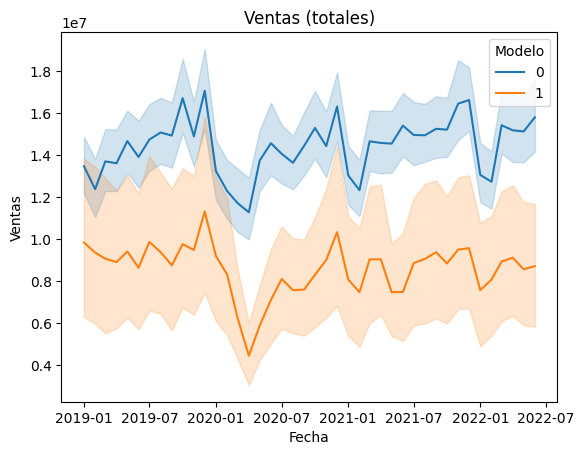

In [17]:
sns.lineplot(x='Fecha', y='Ventas', hue='Modelo', data=ven_mod_t)
plt.title('Ventas (totales)')
plt.show()

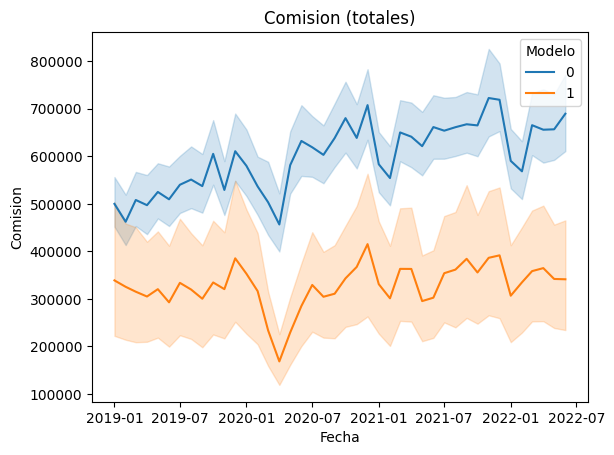

In [18]:
sns.lineplot(x='Fecha', y='Comision', hue='Modelo', data=ven_mod_t)
plt.title('Comision (totales)')
plt.show()

In [19]:
ven_mod_t_pos = ven_mod_t[ven_mod_t['Ventas'] > 0].copy()

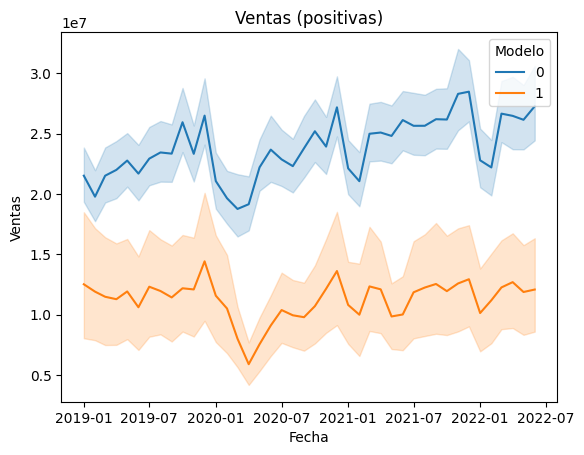

In [20]:
sns.lineplot(x='Fecha', y='Ventas', hue='Modelo', data=ven_mod_t_pos)
plt.title('Ventas (positivas)')
plt.show()

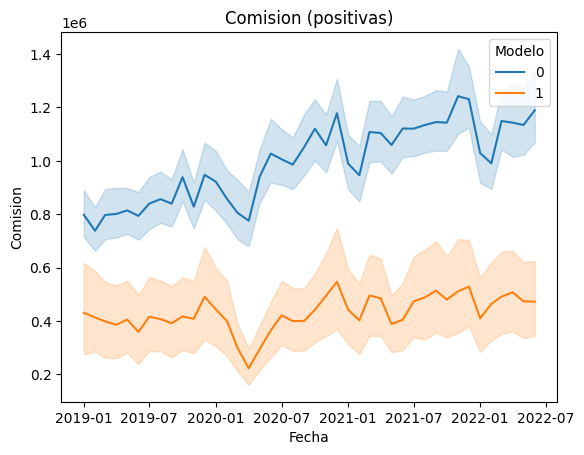

In [21]:
sns.lineplot(x='Fecha', y='Comision', hue='Modelo', data=ven_mod_t_pos)
plt.title('Comision (positivas)')
plt.show()

## Modelos y Subrubros vs. Tiempo

Visualizamos la diferencia entre Modelo y no-Modelo dentro de cada subrubro.

**Observaciones (ventas totales):**
- Los valores de venta en Modelos son menores en todos los Subrubros, con la excepción de tres: "Góndola", "Comb." y "Comb. Ley".
- En los subrubros "Vehículos", "Farmacia" y "Supermercado" los valores de ventas de modelo parecen ser despreciables en comparación con no-Modelo. Tienen valores muy bajos y con muy poca variablidad.
- "Mantenimiento" no parece tener muchos valores Modelo, se podría descartar.

**Observaciones (ventas postivias):**
- Los valores de venta en Modelos son menores en todos los Subrubros, con la excepción de tres: "Góndola" y "Comb.". Ahora "Comb. Ley" se pusieron cabeza a cabeza.
- Se repite lo de "Vehículos", "Farmacia" y "Supermercado".
- "Mantenimiento" no muestra ningún modelo: no hay modelos con ventas positivas en esta categoría

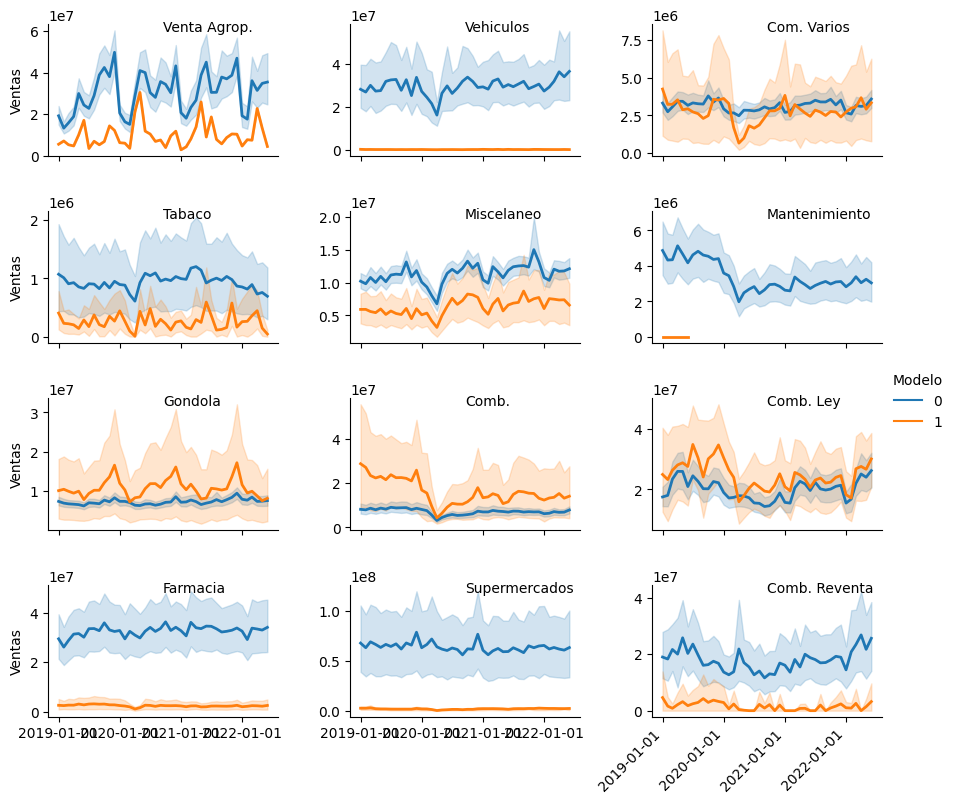

In [34]:
g = sns.relplot(
    data=ventas_fisc,
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

plt.show()

In [37]:
ven_modsub_t_pos = ventas_fisc[ventas_fisc['Ventas'] > 0].copy()

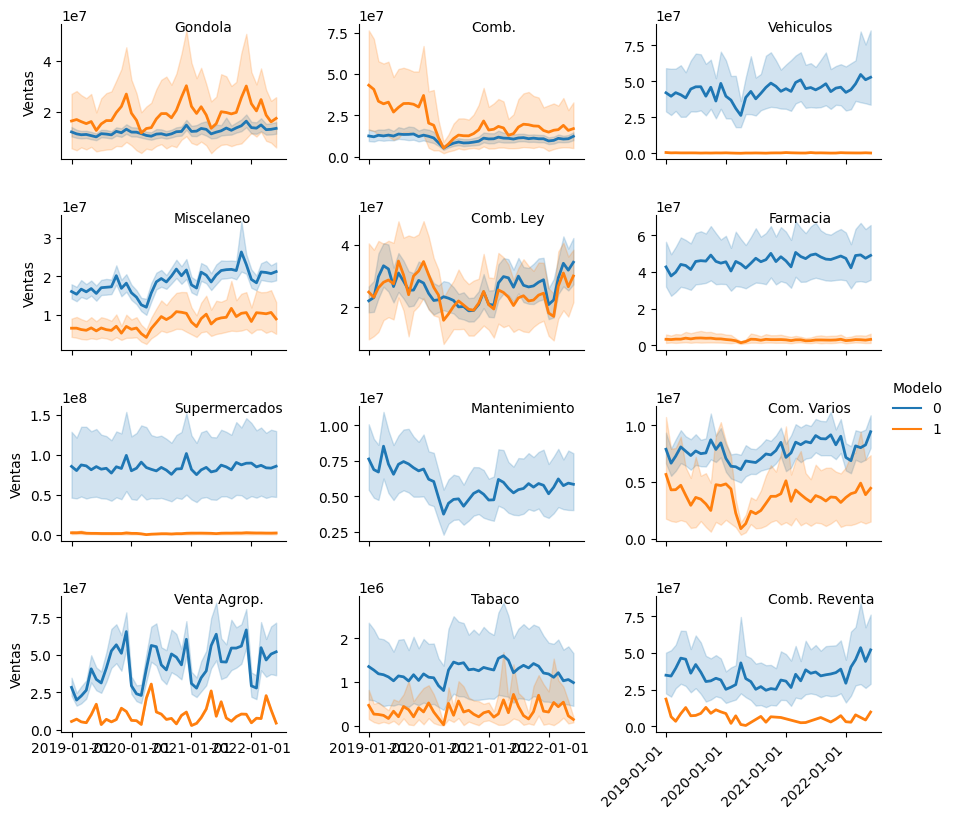

In [38]:
g = sns.relplot(
    data=ven_modsub_t_pos,
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

plt.show()

## Extra: alícuotas en el tiempo
-   Se observa un quiebre en las alícuotas a partir de enero de 2020.
-   Es un salto que se verifica en todos los rubros excepto en los vinculados a combustibles.
-   Otro detalle relevante es que las alicuotas para los Modelo son muy cercanas a 0.

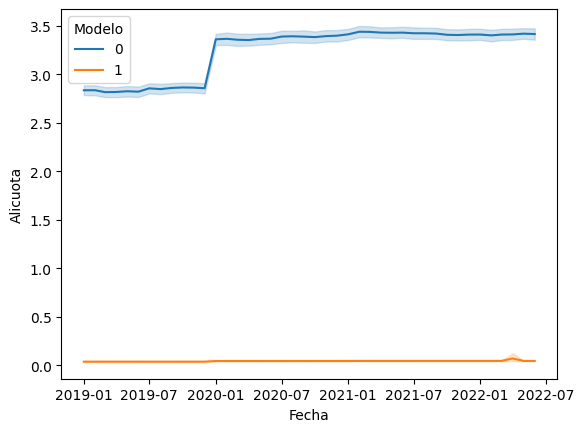

In [35]:
sns.lineplot(x='Fecha', y='Alicuota', hue='Modelo', data=ventas_fisc)

plt.show()

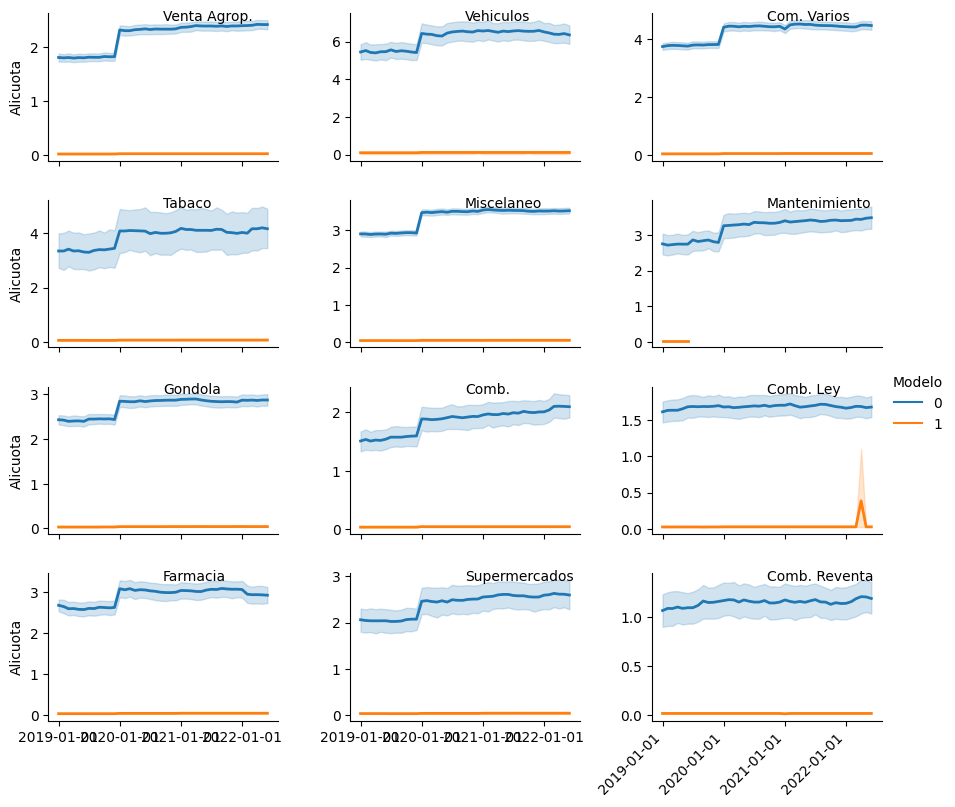

In [36]:
g = sns.relplot(
    data=ventas_fisc,
    x="Fecha", y="Alicuota", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("")
g.set_axis_labels("", "Alicuota")    
#g.tight_layout()

plt.show()

---
# Generación de un nuevo dataset: de transacciones a vendedores <span style="color:magenta">**(Paso 8)**</span>

### Paso 8
Objetivo:
- Una fila por ID*Subrubro 
- Para el último periodo (6 meses por ahora): Generar para cada combinación de ID y Subrubro columnas nuevas que cada una sea el resultado de aplicar la diferencia porcentual de un mes y el anterior

Generamos `ventas_cure` con los siguientes criterios:
- quedarnos sólo con los últimos meses de datos
- eliminar el subrubro "Mantenimiento" porque hay un solo vendedor modelo, con valores nulos en los primeros meses de la serie (que luego desaparece por completo del dataset)

In [ ]:
meses = 6
fecha_corte = ventas_fisc["Fecha"].max() - pd.DateOffset(months=meses)
print (f'Fecha de corte para los últimos {meses} meses: {fecha_corte}')

ventas_cure = ventas_fisc[(ventas_fisc['Fecha'] >= fecha_corte) & 
                         (ventas_fisc['Subrubro'] != 'Mantenimiento')]\
                             .reset_index().copy()
ventas_cure.head()

Generamos `ventas_cure_lean` dropeando algunas columnas que por ahora se ignorarán para caracterizar a cada vendedor

In [ ]:
ventas_cure

In [ ]:
ventas_cure_2 = eliminar_combinacion_vacios(ventas_cure, cols_combina=['ID', 'Subrubro'], col_buscar_vacio='Ventas')
ventas_cure_2

In [ ]:
ventas_cure_por_id_subrubro = ventas_cure_2.groupby(['ID', 'Subrubro']).agg({'Ventas':'sum', 
                                                                                'Alicuota':'mean', 
                                                                                'Comision':'sum'}).reset_index()
ventas_cure_por_id_subrubro

In [ ]:
ventas_cure_lean = ventas_cure\
                    .drop(columns=['index', 'Omega', 'Trat_Fisc', 'Deposito'])\
                    .sort_values(by=['ID', 'Subrubro', 'Fecha'])

ventas_cure_lean

Vendedores `Modelo=1` que pertenecen a más de un subrubro tienen `ventas=0` en algunos subrubros

In [ ]:
# número de subrubros a los que pertenece cada ID Modelo = 1
ventas_cure_lean[ventas_cure_lean["Modelo"]==1]\
    .groupby(['ID'])['Subrubro']\
    .nunique()\
    .sort_values(ascending=False).head(15)

In [ ]:
id = 493

g = sns.relplot(
    data=ventas_cure_lean[ventas_cure_lean['ID'] == id],
    x="Fecha", y="Ventas", col="Subrubro",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

Eliminamos Subrubros dentro de IDs donde tengan 0 ventas en el periodo estudiado:

In [ ]:
ventas_cure_lean = eliminar_combinacion_vacios(ventas_cure_lean, cols_combina=['ID', 'Subrubro'], col_buscar_vacio='Ventas')
ventas_cure_lean

In [ ]:
ventas_cure_lean

Verificar que no exista combinación de ID y Subrubro con ventas agrupadas en el periodo de estudio que sea cero

In [ ]:
ventas_cure_lean.groupby(['ID', 'Subrubro'])['Ventas'].sum().reset_index().sort_values(by='Ventas', ascending=True)

In [ ]:
id = 493

g = sns.relplot(
    data=ventas_cure_lean[ventas_cure_lean['ID'] == id],
    x="Fecha", y="Ventas", col="Subrubro",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

----


In [ ]:
ventas_cure_2

### DF curación simple

Agregar para tener una sola fila por ID*Subrubro

In [ ]:
ventas_cure_por_id_subrubro = ventas_cure_2.groupby(['ID', 'Subrubro']).agg({'Ventas':'sum', 
                                                                                'Alicuota':'mean', 
                                                                                'Comision':'sum'}).reset_index()
ventas_cure_por_id_subrubro

In [ ]:
# variable que tiene cada id único con un valor de si es modelo o no
# sirve para hacer joins depués de los groupbys
id_modelo_referencia = ventas_cure_lean.groupby('ID')['Modelo'].mean().reset_index()
id_modelo_referencia

Este DF sería la versión más simple, sin aumentar columnas:

In [ ]:
ventas_curado_simple = pd.merge(left=ventas_cure_por_id_subrubro, right=id_modelo_referencia, how='left', on='ID', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=None, indicator=False, validate=None)
ventas_curado_simple

### DF con más features
** REVISAR **

Agrupar por ID y Subrubro y luego Calcular la diferencia de Ventas con `.diff()` funciona
PERO a veces se repite porque se hay Depósitos diferentes

Pasos a seguir:
- para cada groupby ID*Subrubro transformar en columnas las diffs, quizás manteniendo un "first" del cada groupby y dropeando después el resto

In [ ]:
ventas_cure_por_id_subrubro_fecha = ventas_cure_2.groupby(['ID', 'Subrubro', 'Fecha']).agg({'Ventas':'sum', 
                                                                                    'Alicuota':'mean', 
                                                                                    'Comision':'sum'}).reset_index()
ventas_cure_por_id_subrubro_fecha

In [ ]:
ventas_cure_por_id_subrubro_fecha['diff_by_id_subrubro'] = ventas_cure_por_id_subrubro_fecha.groupby(['ID','Subrubro'])["Ventas"].diff()
ventas_cure_por_id_subrubro_fecha.head(20)

Pendiente: Convertir cada

-----
A partir de acá es experimental...


In [ ]:
def func_i1_o2(x):
    return pd.Series((x+1, x+2))

func_i1_o2(1)

Agregamos los depósitos para cada ID  
Decisiones tomadas que se pueden rever:
- Ignoramos Omega, Trat_fisc

In [ ]:
ventas_cure_lean.head()

In [ ]:
ventas_cure_lean.groupby(['ID', 'Subrubro', 'Fecha', 'Alicuota', 'Comision'])["Ventas"].sum()#.unstack().reset_index()

In [ ]:
ventas_cure_lean.groupby('Subrubro')["Ventas"].diff()

In [ ]:
ventas_cure["Ventas"].diff()

In [ ]:
# calcular diferencias relativas

ventas_fisc["Ventas"].rolling(3).mean()

Número de IDs con ventas 0 en todo el periodo

In [ ]:
np.sum(ventas_cure_lean.groupby(['ID'])['Ventas'].sum() == 0)

Número de IDs-y-Subrubro que tuvieron ventas 0 en el periodo

In [ ]:
np.sum(ventas_cure_lean.groupby(['ID', 'Subrubro'])['Ventas'].sum() == 0)

# Punto 8 (Pato)

In [ ]:
# Para que las funciones se actualicen si tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones propias
from utils_limpieza import * 
    
ventas_pato = pd.read_csv('../data/interim/tp2_ventas_fisc.csv')

ventas_pato['Fecha'] = ventas_pato['Fecha'].astype('datetime64[ns]')

In [ ]:
ventas_pato

In [ ]:
agregado = ventas_pato.groupby(['ID', 'Subrubro', 'Fecha']).agg({
    'Ventas': 'sum',
    'Alicuota': 'mean',
    'Comision': 'sum',
    'Modelo': 'max'
}).reset_index()
agregado

Con esto, me deshago de las observaciones repetidas por depósito o por tratamiento fiscal

In [ ]:
agregado_no_nulo = agregado.groupby(['ID', 'Subrubro']).filter(lambda x: (x['Ventas'] != 0).any()).copy()
agregado_no_nulo

Con esto me deshice de los ID que para un mismo rubro tienen ventas nulas siempre.

Ahora, debería tener 42 observaciones por ID/Subrubro

In [ ]:
promedio_observaciones = agregado_no_nulo.groupby(['ID', 'Subrubro']).size().mean()

# Mostrar el promedio de observaciones por combinación de ID y Subrubro
print(promedio_observaciones)

No pasa, porque a veces hay meses faltantes. Debo imputar esos meses con valor 0 en ventas (esto es particularmente importante si luego vamos a hacer diferencias, por ej. para que no se encuentre con un vacío o que me opere contra un mes que en realidad no es el anterior)

In [ ]:
# Contar las observaciones por combinación de ID y Subrubro
conteo_combinaciones = agregado_no_nulo.groupby(['ID', 'Subrubro']).size().reset_index(name='Conteo')

# Filtrar las combinaciones con menos de 42 observaciones
combinaciones_faltantes = conteo_combinaciones[conteo_combinaciones['Conteo'] < 42]

# Lista para almacenar las observaciones faltantes
observaciones_faltantes = []

# Iterar sobre las combinaciones faltantes
for _, combinacion in combinaciones_faltantes.iterrows():
    id_val = combinacion['ID']
    subrubro_val = combinacion['Subrubro']
    
    # Obtener fechas existentes y fechas faltantes
    fechas_existentes = agregado_no_nulo[(agregado_no_nulo['ID'] == id_val) & (agregado_no_nulo['Subrubro'] == subrubro_val)]['Fecha']
    fechas_faltantes = set(agregado_no_nulo['Fecha'].unique()) - set(fechas_existentes)
    
    # Agregar observaciones faltantes al DataFrame
    for fecha_faltante in fechas_faltantes:
        observacion = {
            'ID': id_val,
            'Subrubro': subrubro_val,
            'Fecha': fecha_faltante,
            'Ventas': 0,
            'Alicuota': '',
            'Comision': 0,
            'Modelo': agregado_no_nulo[(agregado_no_nulo['ID'] == id_val) & (agregado_no_nulo['Subrubro'] == subrubro_val)]['Modelo'].mean()
        }
        observaciones_faltantes.append(observacion)

# Crear DataFrame con las observaciones faltantes
df_observaciones_faltantes = pd.DataFrame(observaciones_faltantes)

# Agregar observaciones faltantes al DataFrame agregado_no_nulo
agregado_limpio = pd.concat([agregado_no_nulo, df_observaciones_faltantes], ignore_index=True)

# Mostrar el nuevo DataFrame con las observaciones faltantes agregadas
agregado_limpio

In [ ]:
promedio_observaciones = agregado_limpio.groupby(['ID', 'Subrubro']).size().mean()

# Mostrar el promedio de observaciones por combinación de ID y Subrubro
print(promedio_observaciones)

In [ ]:
agregado_limpio.to_csv('../data/interim/tp2_agregado_limpio.csv', index=False)

In [ ]:
path = '../data/interim/tp2_agregado_limpio.csv'
agregado_limpio = pd.read_csv(path)

In [ ]:
agregado_limpio = agregado_limpio.drop('Alicuota', axis=1)
agregado_limpio = agregado_limpio.sort_values(['Subrubro', 'ID', 'Fecha'])

In [ ]:
agregado_limpio['Dif_Ventas'] = agregado_limpio.groupby(['ID', 'Subrubro'])['Ventas'].diff()
agregado_limpio['Dif_Comision'] = agregado_limpio.groupby(['ID', 'Subrubro'])['Comision'].diff()

In [ ]:
agregado_limpio[(agregado_limpio['ID'] == 5) & (agregado_limpio['Subrubro'] == 'Com. Varios')]